In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import fp_loader_configer

fp_loader_configer.select_version("MFP_Specific_Radius")
specific_radius_mfp_loader = fp_loader_configer.fp_loader

import pickle     

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


In [3]:
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [4]:
from inference.inference_utils import choose_model
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK


In [5]:

hparams, model , test_loader = choose_model("C-NMR")


Normal
max_radius:  3
loading time: 32.59941482543945
counting time: 13.975774049758911
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [6]:
hparams['FP_building_type'].split("_")[-1]

'Normal'

In [7]:
# model = OptionalInputRankedTransformer.load_from_checkpoint(Path("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_c_trial_1/checkpoints/epoch=16-step=27472.ckpt"), **hparams)

In [8]:


# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

In [9]:
model.device

device(type='cuda', index=0)

In [10]:
# set up ranking set

choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))


all_FP_indices_in_folder = pickle.load(open(f'/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [11]:
for k,v in index_to_smiles.items():
    if v == "COC1OC(CO)C(O)C(O)C1O":
        print(k)
        break

9995


In [12]:
max_radius = specific_radius_mfp_loader.max_radius
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [13]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

(526316, 526316)

############################################### compound number: 1##############################################################
Ground Truth NMR
Chemical name METHYL GALACTOSIDE
Ground truth smiles COC1OC(CO)C(O)C(O)C1O


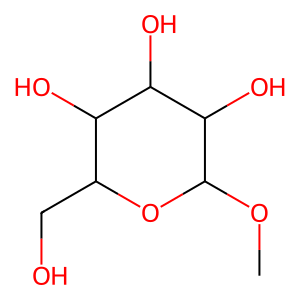

Prediction's cosine similarity to ground truth:  0.8996251821517944
________retival #1, cosine similarity to prediction: 0.9044914841651917_________________
SMILES: COC1OC(CO)C(O)C1O
Name "(2~{S},3~{R},4~{R},5~{R})-2-(hydroxymethyl)-5-methoxy-tetrahydrofuran-3,4-diol"


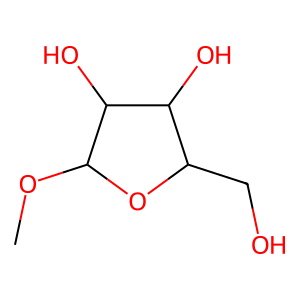

________retival #2, cosine similarity to prediction: 0.8996242880821228_________________
SMILES: COC1OC(CO)C(O)C(O)C1O
Name "(2~{S},3~{R},4~{R},5~{S},6~{S})-2-(hydroxymethyl)-6-methoxy-tetrahydropyran-3,4,5-triol"


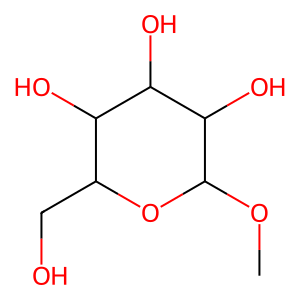

________retival #3, cosine similarity to prediction: 0.8621717095375061_________________
SMILES: CC(C)OC1OC(CO)C(O)C(O)C1O
Name "(2~{R},3~{S},4~{S},5~{R},6~{R})-2-(hydroxymethyl)-6-isopropoxy-tetrahydropyran-3,4,5-triol"


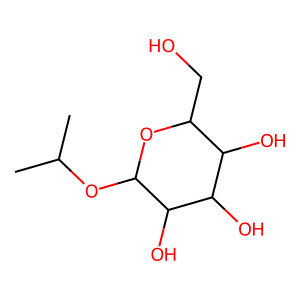

DONE






In [14]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
for which_compound in range(0, 1):
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(test_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    # plot_NMR(hsqc, c_tensor, h_tensor)
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=3)
    # ground truth
    # smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
    # 
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [15]:
# '''
# temp feature:
# compute rank-1 on inference set
# '''
# from tqdm import tqdm

# rankingset_data = rankingset_data.to(model.device)
# # for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
# accu = [] 
    
# for idx, batch in tqdm(enumerate(test_loader)):
        
#     inputs, extra_info = batch
#     (smiles, names, NMR_type_indicator, path) = zip(*extra_info)
#     # print(inputs.shape, inputs)
#     # print(inputs, smiles_chemical_name)
    
#     # batch[0] = batch[0].to("cuda")
#     # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])

#     inputs = inputs.to(model.device)
#     NMR_type_indicator = NMR_type_indicator[0].to(model.device)
#     pred = model(inputs, NMR_type_indicator)
#     pred=torch.sigmoid(pred) # sigmoid
#     pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)

    
#     topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
#     # ground truth
    
#     ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
#     # print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
#     # 
#     i=0
#     for value, (smile, name, _, _), retrieved_FP in topk:
#         # print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
#         # mol = Chem.MolFromSmiles(smile)
#         # # print("retrived FP", retrieved_FP.squeeze().tolist())

#         # print(f"SMILES: {smile}") 
#         # print(f"Name {name}")
#         # img = Draw.MolToImage(mol)
#         # img.show()
#         # i+=1
#         # accu.append(smile == smiles[0])
#         # accu.append(pred_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
#         accu.append(ground_truth_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
#     # if smile == smiles[0]:
#     #     break
    
# print("DONE\n\n\n\n")

# np.mean(accu)        



In [16]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [17]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1

In [18]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


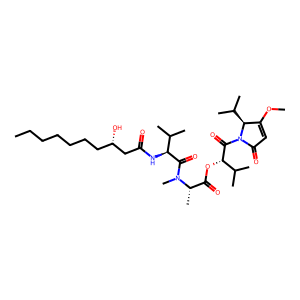

In [19]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img.show()

In [20]:
# retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=5)

In [21]:
deepSAT_sintokamide_B_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES("CCC(=O)N[C@H](C[C@H](C)C(Cl)(Cl)Cl)C(=O)N1[C@H](C(=CC1=O)OC)C[C@H](C)C(Cl)(Cl)Cl")
compute_cos_sim(deepSAT_sintokamide_B_FP, Kavaratamide_A_FP)

tensor(0.5710234046)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.4746380150)



________retival #1, cosine similarity to prediction: 0.644216775894165_________________
SMILES: CCCCC(=O)OC1CC(C)CCC1C(C)C
Name (2-isopropyl-5-methyl-cyclohexyl) pentanoate


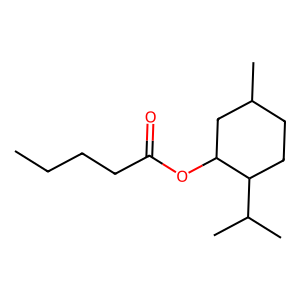

________retival #2, cosine similarity to prediction: 0.6438631415367126_________________
SMILES: CCCCCC(O)CC(=O)NC1CCOC1=O
Name (3~{S})-3-hydroxy-~{N}-[(3~{S})-2-oxotetrahydrofuran-3-yl]octanamide


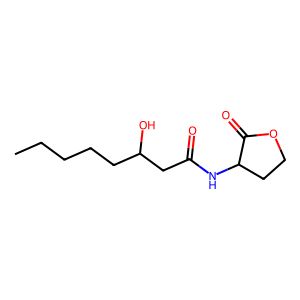

________retival #3, cosine similarity to prediction: 0.6415068507194519_________________
SMILES: CCCCCCCCCCCCCCCCOC(=O)C(CC(C)C)NC(=O)C1CC1
Name hexadecyl 2-(cyclopropanecarbonylamino)-4-methyl-pentanoate


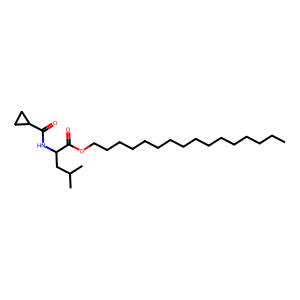

['CCCCC(=O)OC1CC(C)CCC1C(C)C',
 'CCCCCC(O)CC(=O)NC1CCOC1=O',
 'CCCCCCCCCCCCCCCCOC(=O)C(CC(C)C)NC(=O)C1CC1']

In [22]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "MFP_Specific_Radius")
                   

In [23]:
# inputs

In [24]:
def investigate_new_molecule(compound_dir, SMILES):
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model(model_type)
        max_radius = specific_radius_mfp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [25]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)




Kavaratamide A


Normal
max_radius:  2
loading time: 3.1270158290863037
counting time: 13.155852317810059
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: All-NMR, max_radius: 2



Kavaratamide A


Normal
max_radius:  4
loading time: 2.6699538230895996
counting time: 8.320643424987793
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC, max_radius: 4



Kavaratamide A


Normal
max_radius:  3
loading time: 2.13169264793396
counting time: 13.260138511657715
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: C-NMR, max_radius: 3



Kavaratamide A


Normal
max_radius:  3


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: H-NMR, max_radius: 3



Kavaratamide A


Normal
max_radius:  2
loading time: 2.235123634338379
counting time: 13.37441349029541
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_C-NMR, max_radius: 2



Kavaratamide A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_H-NMR, max_radius: 2



Kavaratamide A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d, max_radius: 2



Kavaratamide A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d_DTD, max_radius: 2



Kavaratamide A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_C-NMR_DTD, max_radius: 2


In [26]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)

In [27]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"

# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3, ground_truth_FP=newCompoundA_FP)

investigate_new_molecule(compound_dir, newCompoundA_SMILES)




new_compound_A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: All-NMR, max_radius: 2



new_compound_A


Normal
max_radius:  4
loading time: 2.2971246242523193
counting time: 8.339228868484497
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC, max_radius: 4



new_compound_A


Normal
max_radius:  3
loading time: 2.1836564540863037
counting time: 13.570495843887329
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: C-NMR, max_radius: 3



new_compound_A


Normal
max_radius:  3


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: H-NMR, max_radius: 3



new_compound_A


Normal
max_radius:  2
loading time: 2.2139968872070312
counting time: 13.5121431350708
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_C-NMR, max_radius: 2



new_compound_A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_H-NMR, max_radius: 2



new_compound_A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d, max_radius: 2



new_compound_A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d_DTD, max_radius: 2



new_compound_A


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_C-NMR_DTD, max_radius: 2


In [28]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)




new_compound_B1


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: All-NMR, max_radius: 2



new_compound_B1


Normal
max_radius:  4
loading time: 2.3334407806396484
counting time: 8.340882539749146
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC, max_radius: 4



new_compound_B1


Normal
max_radius:  3
loading time: 2.160229444503784
counting time: 14.182291746139526
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: C-NMR, max_radius: 3



new_compound_B1


Normal
max_radius:  3


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: H-NMR, max_radius: 3



new_compound_B1


Normal
max_radius:  2
loading time: 2.3113319873809814
counting time: 13.597426652908325
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_C-NMR, max_radius: 2



new_compound_B1


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_H-NMR, max_radius: 2



new_compound_B1


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d, max_radius: 2



new_compound_B1


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d_DTD, max_radius: 2



new_compound_B1


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_C-NMR_DTD, max_radius: 2


In [29]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)




new_compound_B2




Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: All-NMR, max_radius: 2



new_compound_B2


Normal
max_radius:  4
loading time: 2.30220365524292
counting time: 8.402037858963013
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC, max_radius: 4



new_compound_B2


Normal
max_radius:  3
loading time: 2.1696791648864746
counting time: 13.725626945495605
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: C-NMR, max_radius: 3



new_compound_B2


Normal
max_radius:  3


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: H-NMR, max_radius: 3



new_compound_B2


Normal
max_radius:  2
loading time: 2.3592278957366943
counting time: 13.718299627304077
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_C-NMR, max_radius: 2



new_compound_B2


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: HSQC_H-NMR, max_radius: 2



new_compound_B2


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d, max_radius: 2



new_compound_B2


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_1d_DTD, max_radius: 2



new_compound_B2


Normal
max_radius:  2


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
Model type: only_C-NMR_DTD, max_radius: 2
